In [1]:
# libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Epydemix import
from epydemix.population import Population
from epydemix.epimodel import EpiModel
from epydemix.plotting import plot_quantiles

# Population Object

In [2]:
population = Population(name="Indonesia")

# add contact matrices
population.add_contact_matrix(np.load("./basins/Indonesia/contacts-matrix/contacts_matrix_work.npz")["arr_0"], 
                              layer_name="work")
population.add_contact_matrix(np.load("./basins/Indonesia/contacts-matrix/contacts_matrix_home.npz")["arr_0"], 
                              layer_name="home")
population.add_contact_matrix(np.load("./basins/Indonesia/contacts-matrix/contacts_matrix_community.npz")["arr_0"], 
                              layer_name="community")
population.add_contact_matrix(np.load("./basins/Indonesia/contacts-matrix/contacts_matrix_school.npz")["arr_0"], 
                              layer_name="school")

# add population in different age groups
population.add_population(Nk=pd.read_csv("./basins/Indonesia/demographic/Nk.csv")["value"].values, 
                          Nk_names=pd.read_csv("./basins/Indonesia/demographic/Nk.csv")["group"].values)

# EpiModel Object

In [3]:
# create model 
model = EpiModel(compartments=["S", "I"])

# add compartments
model.add_compartments("R")

# add transitions 
model.add_transition(source="S", target="I", rate=0.04, rate_name="beta", agent="I")
model.add_transition(source="I", target="R", rate=0.1, rate_name="mu")

# add interventions
model.add_intervention(layer_name="work", start_date="2020-01-01", end_date="2020-05-01", reduction_factor=0.3)
#model.add_intervention(layer_name="school", start_date="2020-01-01", end_date="2020-02-01", new_matrix=population.contact_matrices["community"])


In [4]:
compartments, df_quantiles = model.simulate(population=population, 
                              start_date="2019-12-01", 
                              end_date="2020-06-01", 
                              S=population.Nk - np.ones(len(population.Nk)),
                              I=np.ones(len(population.Nk)),
                              R=np.zeros(len(population.Nk)),
                              steps=100)

(100, 100, 3, 16)

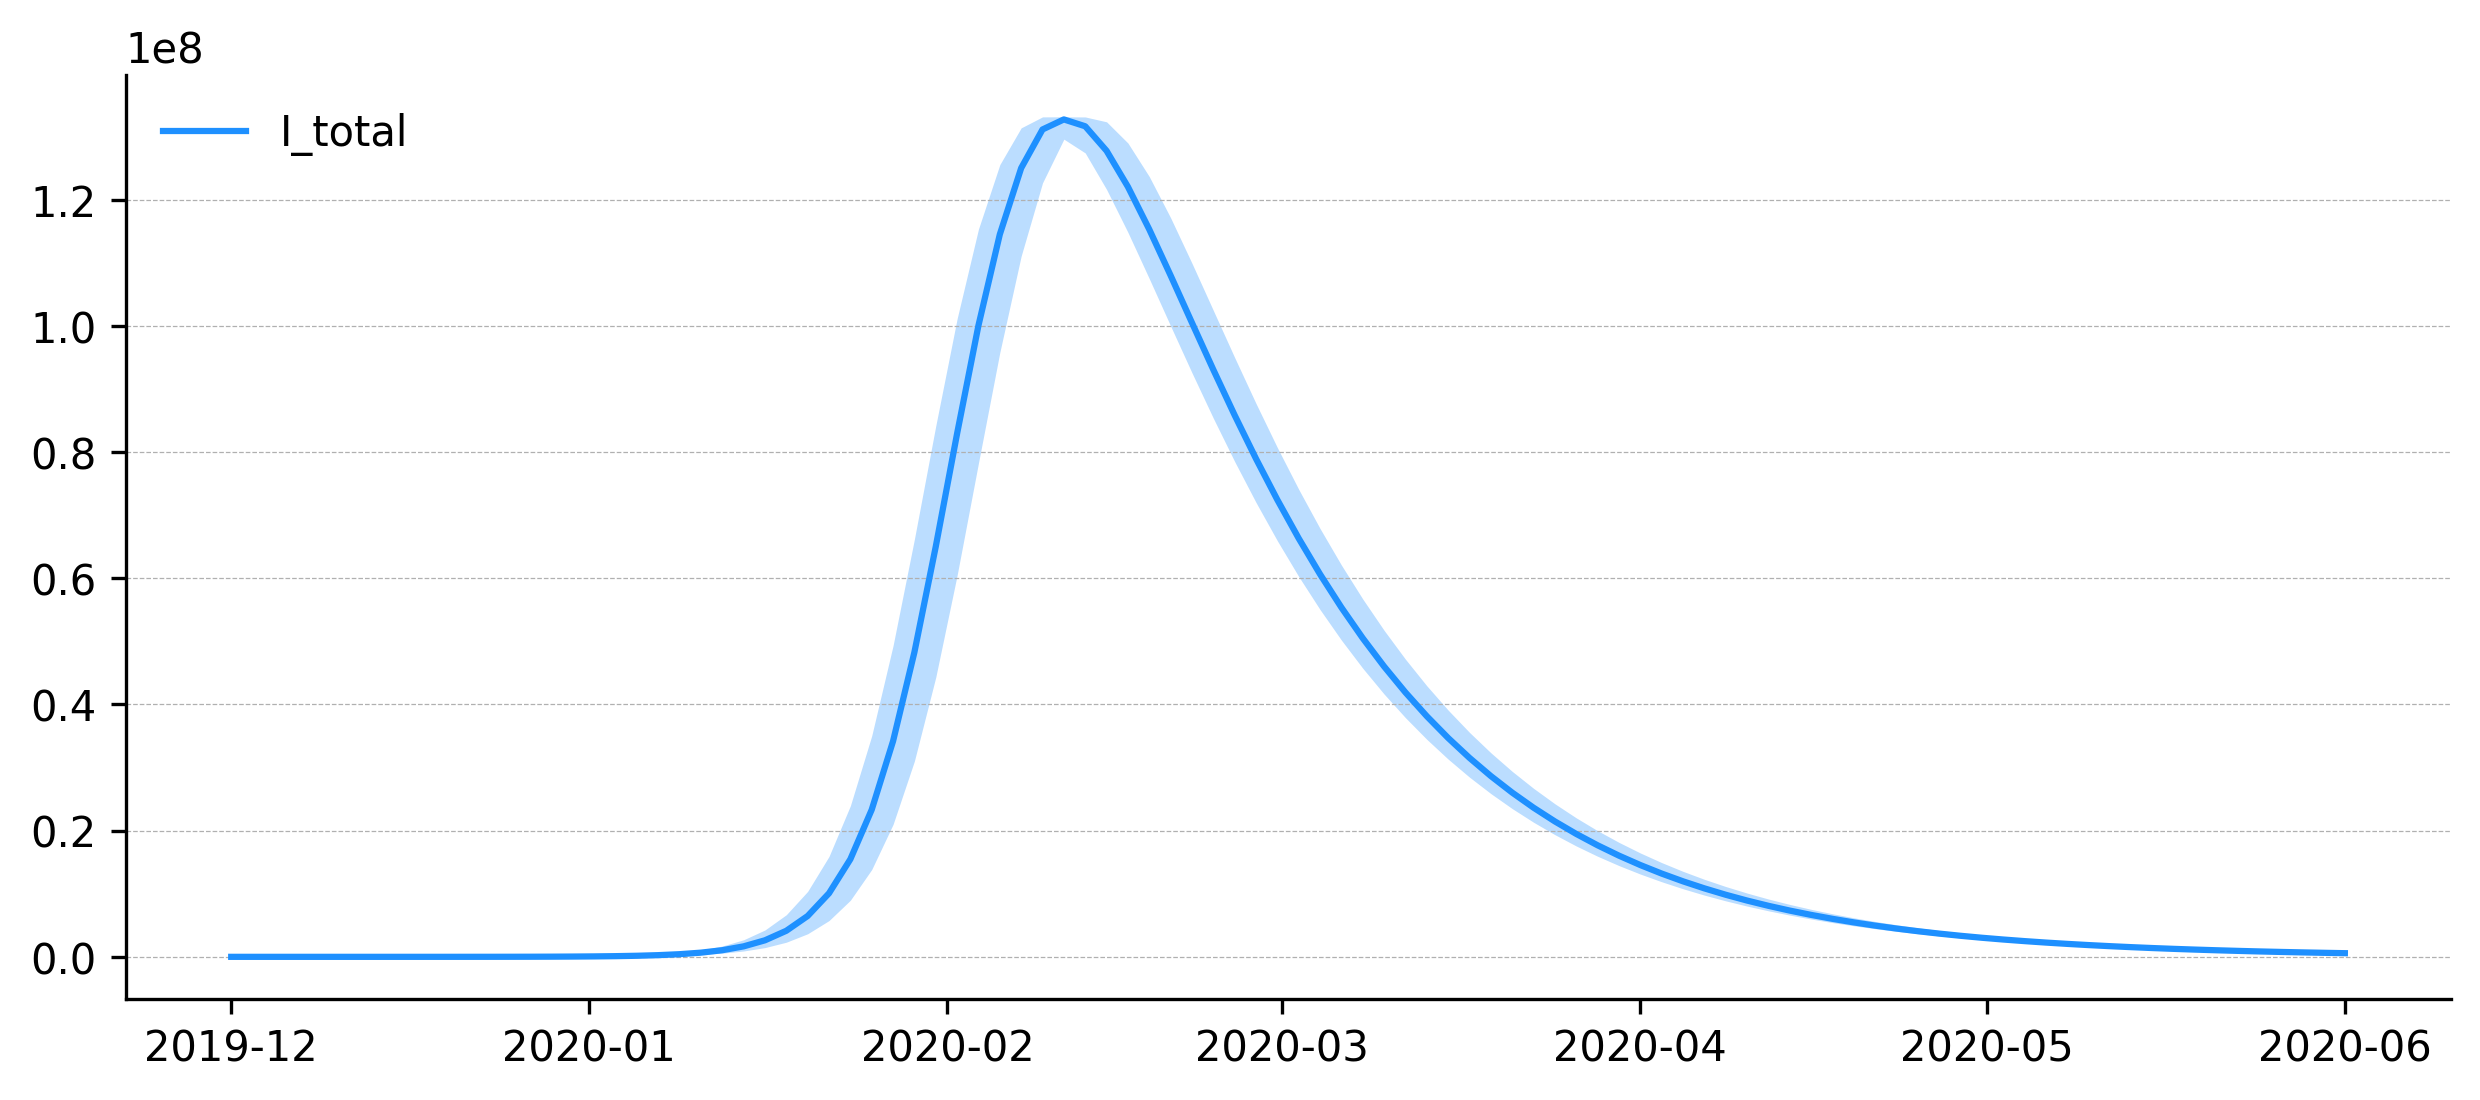

In [6]:
plot_quantiles(df_quantiles, compartment="I", demographic_group="total", label="I_total")

In [ ]:
%timeit model.simulate(population=population, start_date="2019-12-01",  end_date="2020-06-01",  S=population.Nk - np.ones(len(population.Nk)),  I=np.ones(len(population.Nk)), R=np.zeros(len(population.Nk)),steps=100, Nsim=100)

# Toy Model with Interventions

In [ ]:
model = Epydemix()

# simulation dates
start_date, end_date = datetime(2022, 1, 1), datetime(2022, 12, 31)

# Number of stochastic simulations 
Nsim = 10

# define epidemic model (SEIR)
model.add_interaction("S", "E", "I", 0.05, rate_name="beta")
model.add_spontaneous("E", "I", 1. / 4., rate_name="eps")
model.add_spontaneous("I", "R", 1. / 2.5, rate_name="mu")

# simulate without interventions
simulations = model.simulate(start_date=start_date, 
                             end_date=end_date, Nsim=Nsim, 
                             S=model.basin.Nk - np.ones(model.n_age),
                             I=np.ones(model.n_age),
                             R=np.zeros(model.n_age))

# simulate with interventions
model.add_intervention(start_date=datetime(2022, 3, 1), 
                       end_date=datetime(2022, 6, 1), 
                       layer="school", 
                       factor=0.344)

model.add_intervention(start_date=datetime(2022, 3, 15), 
                       end_date=datetime(2022, 9, 1), 
                       layer="work", 
                       factor=0.5)

model.add_intervention(start_date=datetime(2022, 4, 1), 
                       end_date=datetime(2022, 8, 1), 
                       layer="community", 
                       factor=0.8)

simulations_npis = model.simulate(start_date=start_date, 
                             end_date=end_date, Nsim=Nsim, 
                             S=model.basin.Nk - np.ones(model.n_age),
                             I=np.ones(model.n_age),
                             R=np.zeros(model.n_age))

In [ ]:
plt.plot(np.quantile(simulations, axis=0, q=0.5).sum(axis=2)[:, 2], label="without intervention")
plt.plot(np.quantile(simulations_npis, axis=0, q=0.5).sum(axis=2)[:, 2], label="with intervention")
plt.ylabel("Number of infected")
plt.legend()

In [ ]:
# plot impact of intervention on spectral radius 
model.plot_spectral_radius()

# Complex Compartmentalization Setup

In [ ]:
model = Epydemix()

# simulation dates
start_date, end_date = datetime(2022, 1, 1), datetime(2022, 12, 31)

# Number of stochastic simulations 
Nsim = 10

# define epidemic model (SEPIAR)
model.add_interaction("S", "E", "I", 0.05, rate_name="beta")
model.add_interaction("S", "E", "IA", 0.05 * 0.7, rate_name="beta_asymp")
model.add_spontaneous("E", "P", 1. / 2., rate_name="gamma")
model.add_spontaneous("P", "I", 1. / 2. * 0.7, rate_name="eps_inf")
model.add_spontaneous("P", "IA", 1. / 2. * 0.3, rate_name="eps_asymp")
model.add_spontaneous("I", "R", 1. / 2.5, rate_name="mu")
model.add_spontaneous("IA", "RA", 1. / 2.5, rate_name="mu_asymp")

# simulate without interventions
simulations = model.simulate(start_date=start_date, 
                             end_date=end_date, Nsim=Nsim, 
                             S=model.basin.Nk - np.ones(model.n_age),
                             I=np.ones(model.n_age),
                             R=np.zeros(model.n_age))

In [ ]:
for k, v in model.pos.items(): 
    plt.plot(np.quantile(simulations, axis=0, q=0.5).sum(axis=2)[:, v], label=k)
plt.legend()

In [ ]:
model = Epydemix()

# define epidemic model (SEIR)
model.add_interaction("S", "E", "I1", 0.05, rate_name="beta1")
model.add_interaction("S", "E", "I2", 0.05, rate_name="beta2")

In [ ]:
list(model.transitions.edges(data=True))[0]

In [ ]:
model = Epydemix()

# simulation dates
start_date, end_date = datetime(2022, 1, 1), datetime(2022, 12, 31)

# Number of stochastic simulations 
Nsim = 1

# define epidemic model (SEIR)
model.add_interaction("S", "E", "I", 0.05, rate_name="beta")
model.add_spontaneous("E", "I", 1. / 4., rate_name="eps")
model.add_spontaneous("I", "R", 1. / 2.5, rate_name="mu")

In [ ]:
%timeit model.simulate(start_date=start_date,  end_date=end_date, Nsim=Nsim,  S=model.basin.Nk - np.ones(model.n_age),  I=np.ones(model.n_age),            R=np.zeros(model.n_age))